Pre-allocate NUM_SUPER_BATCHES x 'super batch tensors' in GPU RAM.  Each super batch has a READY flag (which tells the PyTorch dataloader 'this super batch is ready to sample from')

(Paralelise using dask.delayed):

PyTorch Dataset then randomly samples squares to create a batch.


In [313]:
import numpy as np
from multiprocessing import managers, shared_memory
import enum
from concurrent import futures
import xarray as xr
import gcsfs
from typing import Dict, List
import torch
from collections import namedtuple
from dataclasses import dataclass
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt

In [45]:
# Override is_retriable.  Google Cloud sometimes throws
# a HttpError code 400.  gcsfs considers this to not be retriable.
# But it is retriable!

def is_retriable(exception):
    """Returns True if this exception is retriable."""
    errs = list(range(500, 505)) + [
        # Jack's addition.  Google Cloud occasionally throws Bad Requests for no apparent reason.
        400,
        # Request Timeout
        408,
        # Too Many Requests
        429,
    ]
    errs += [str(e) for e in errs]
    if isinstance(exception, gcsfs.utils.HttpError):
        return exception.code in errs

    return isinstance(exception, gcsfs.utils.RETRIABLE_EXCEPTIONS)

gcsfs.utils.is_retriable = is_retriable

In [46]:
ZARR = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'
gcs = gcsfs.GCSFileSystem()
gcs.retries = 60
store = gcsfs.GCSMap(root=ZARR, gcs=gcs)

In [48]:
%%time
dataset = xr.open_zarr(store, consolidated=True)

CPU times: user 5.29 s, sys: 402 ms, total: 5.69 s
Wall time: 2min 31s


In [268]:
OPT_FLOW_DTYPE = np.float32


class BatchType(enum.Enum):
    TRAINING = 0
    TESTING = 1


def convert_10bpp_to_uint8(array):
    "Convert 10 bit per pixel to uint8"
    # Divide by 4 to get from a range of [0, 1023] to [0, 255].
    array = array / 4.0
    array = array.round()
    assert array.min() >= 0
    assert array.max() <= 255
    return array.astype(np.uint8)


def _compute_optical_flow_worker_process(
    timestep: int, 
    sat_data_shape: tuple, 
    sat_data_shared_mem: shared_memory.SharedMemory, 
    opt_flow_shared_mem: shared_memory.SharedMemory) -> None:
    """Separate process. Gets sat data from shared memory. Computes optical flow
    for pair of images timestep and timestep+1.
    
    Args:
        timestep: Index into sat_data for the first image on which to compute
            optical flow.  The 2nd image is timestep+1.
        sat_data_shape: Tuple of (num_timesteps, height, width)
        sat_data_shared_mem: SharedMemory object.  Note that the full array isn't copied into
            each process.  Instead, memory is shared between processes.
        opt_flow_shared_mem: SharedMemory into which this function inserts the computed optical flow field.
    """
    # Attach to existing memory block for satellite data.
    sat_data_shared_array = np.ndarray(sat_data_shape, dtype=np.uint8, buffer=sat_data_shared_mem.buf)
    
    # Attach to existing memory block for the optical flow fields.
    num_timesteps, height, width = sat_data_shape
    opt_flow_shape = (num_timesteps-1, height, width, 2)
    opt_flow_shared_array = np.ndarray(opt_flow_shape, dtype=OPT_FLOW_DTYPE, buffer=opt_flow_shared_mem.buf)
    
    prev_img = sat_data_shared_array[timestep]
    next_img = sat_data_shared_array[timestep+1]
    
    flow = cv.calcOpticalFlowFarneback(
        prev=prev_img, next=next_img, flow=None, pyr_scale=0.5, levels=2, winsize=40, iterations=3, 
        poly_n=5, poly_sigma=0.7, flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)
    
    # Copy flow to shared memory.
    opt_flow_shared_array[timestep] = flow[:]


def compute_optical_flow(sat_data: xr.DataArray) -> xr.DataArray:
    """Compute optical flow for each pair of consecutive images using multiple processes.

    Args:
        sat_data: Satellite data loaded from disk.
        
    Returns:
        optical flow fields as xr.DataArray, with the 'time' dimension set to the time
        of the second of the pair of input satellite images.
    """
    # OpenCV expects uint8 images
    sat_data_uint8 = convert_10bpp_to_uint8(sat_data)
    num_timesteps, height, width = sat_data_uint8.shape

    # Create a non-shared array for the resulting optical flow fields.
    num_flows = num_timesteps - 2
    opt_flow_shape = (num_flows, height, width, 2)
    opt_flow_array = np.empty(opt_flow_shape, dtype=OPT_FLOW_DTYPE)

    # To speed up processing, we use multiple processes to compute the optical flow fields.
    # Prior to Python 3.8, we'd have to pass the sat data array and the optical flow
    # arrays using pipes or on-disk files.  That's slow.  Python 3.8 allows us to share
    # memory between processes, which is much faster.
    with managers.SharedMemoryManager() as smm:
        # Create shared array for the uint8 satellite imagery.
        sat_data_shared_mem = smm.SharedMemory(size=sat_data_uint8.nbytes)
        sat_data_shared_array = np.ndarray(sat_data_uint8.shape, dtype=np.uint8, buffer=sat_data_shared_mem.buf)
        sat_data_shared_array[:] = sat_data_uint8[:]

        # Create a shared array for the resulting optical flow fields.
        opt_flow_shared_mem = smm.SharedMemory(size=opt_flow_array.nbytes)
        opt_flow_shared_array = np.ndarray(opt_flow_shape, dtype=OPT_FLOW_DTYPE, buffer=opt_flow_shared_mem.buf)

        # Fire up a bunch of processes to compute optical flow indexed on the first
        # image of the pair of images to compute optical flow for.  ProcessPoolExecutor
        # defaults to use the number of processors on the machine.
        
        opt_flow_func = partial(
            _compute_optical_flow_worker_process, 
            sat_data_shape=sat_data_uint8.shape,
            sat_data_shared_mem=sat_data_shared_mem,
            opt_flow_shared_mem=opt_flow_shared_mem)
        with futures.ProcessPoolExecutor() as executor:
            executor.map(opt_flow_func, range(num_flows))

        # Copy results into non-shared array.
        opt_flow_array[:] = opt_flow_shared_array[:]

    # Wrap opt_flow_array in an xr.DataArray with appropriate dimensions.
    coords = (
        ('time', sat_data['time'][1:-1]),
        ('y', sat_data['y']),
        ('x', sat_data['x']),
        ('optical_flow_displacement', ['x', 'y']))
    
    return xr.DataArray(opt_flow_array, coords=coords, name='optical flow')

In [309]:
def remap_image(image: np.ndarray, flow: np.ndarray) -> np.ndarray:
    """Takes an image and warps it forwards in time according to the flow field.
    
    Args:
        image: The grayscale image to warp.
        flow: A 3D array.  The first two dimensions must be the same size as the first two
            dimensions of the image.  The third dimension represented the x and y displacement.
            
    Returns:  Warped image.
    """
    # Adapted from https://github.com/opencv/opencv/issues/11068
    height, width = flow.shape[:2]
    remap = -flow.copy()
    remap[..., 0] += np.arange(width)  # map_x
    remap[..., 1] += np.arange(height)[:, np.newaxis]  # map_y
    return cv.remap(src=image, map1=remap, map2=None, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)


def compute_optical_flow_predictions(sat_data: xr.DataArray, flows: xr.DataArray):
    """Compute predictions.

    For each source image (S), and optical flow field (F), we create a predicted image (P) like this:

    source image timestep: 012345
                           SSSSSS
                            FFFF
                             PPPP
                              PPP
                               PP
                                P

    For n source images, we have n-2 flows, and (n-2)*(n-1)/2 predictions.  In the illustration,
    we have 6 source images, 4 flows, and 10 predictions.

    Source image 0 and 1 make the first flow.  Source image 0 and the first flow go into
    making the first prediction (which is for source timestep 2.  That is, we take source image
    1 and predict source image 2.)
    
    Returns metadata, predictions
        metadata: a list of dicts. Each dict has keys 'date_forecast_about' (np.datetime64)
          and 'forecast_horizon' (np.timedelta64).  There is one metadata entry for each prediction.
        predictions: np.ndarray of shape (num_predictions, height, width)
    """

    num_source_timesteps, height, width = sat_data.shape
    num_predictions = int((num_source_timesteps-2) * (num_source_timesteps-1) / 2)
    predictions_shape = (num_predictions, height, width)
    predictions = np.empty(predictions_shape, dtype=np.float32)

    num_flows = num_source_timesteps - 2
    prediction_i = 0
    prediction_metadata = []

    for flow_i in range(num_flows):
        print(f'FLOW {flow_i:02d}: ', end='')
        for forecast_horizon in range(1, (num_flows - flow_i)+1):
            print(f'{prediction_i:03d}, ', end='')
            first_image = sat_data[flow_i+1]
            predicted_image = remap_image(first_image.values, flows[flow_i].values * forecast_horizon)
            predictions[prediction_i] = predicted_image[:]

            forecast_horizon_td = np.timedelta64(forecast_horizon * MINUTES_PER_TIMESTEP, 'm')
            prediction_metadata.append({
                'date_forecast_about': first_image['time'].values + forecast_horizon_td,
                'forecast_horizon': forecast_horizon_td})
            prediction_i += 1
        print()
        
    return prediction_metadata, predictions

In [273]:
TIMESTEPS_PER_HOUR = 12  # One timestep every 5 minutes.
MINUTES_PER_TIMESTEP = 5
NUM_RETRIES = 5

DateRange = namedtuple('DateRange', ['start', 'end'])

@dataclass
class SatelliteLoader:
    """Continually loads satellite data from disk into GPU memory.
    
    Optical flow & optical flow predictions are computed in parallel on the fly.
    
    When data is ready, a 'super batch' is loaded into GPU RAM.
    A 'super batch' is a large number of examples in GPU RAM.
    
    When in 'steady state', there will be num_training_super_batches
    in GPU RAM at once.  This class replaces super batches in a round-robbin
    fashion as new data is loaded off disk.
    
    Calling the __iter__ method will construct a mini-batch by randomly
    sampling from all the super batches in GPU RAM.  In this way, we can
    keep the GPU continually training, while gradually replacing the
    training data as data is loaded off disk.
    
    We don't explicity set a date range for training so the code can 
    automatically make use of new training data when the dataset is updated
    with new satellite data.

    Init params:
        dataset: xarray dataset of int16 EUMETSAT satellite images.
        num_epochs:
        num_forecast_timesteps: Number of timesteps ahead to predict.  Each timestep is 5 minutes long.
        num_examples_per_batch:
        num_batches_per_super_batch:
        num_training_super_batches:
        image_crop_size: __iter__ will return images image_crop_size x image_crop_size.
        testing_date_range: Date range to exclude from training data.  
            If the testing_date_range contains more data
            than can fit into a single super batch then the chronologically late
            data will not be used in either training or testing.
        rng: Random number generator.
    """
    dataset: xr.Dataset  # The only variable that _has_ to be passed in.
    num_epochs: int = 20
    num_forecast_timesteps: int = 24
    num_examples_per_batch: int = 64
    num_batches_per_super_batch: int = 64
    num_training_super_batches: int = 8
    image_crop_size: int = 64

    # TODO: Accept multiple date ranges.
    testing_date_range: DateRange = DateRange(start=np.datetime64('2019-06-01'), end=np.datetime64('2019-06-14'))
        
    rng: np.random.Generator = np.random.default_rng()

    def __post_init__(self):
        # Select just the HRV channel.
        data_array = self.dataset['stacked_eumetsat_data'][..., 0]

        # Our int16 array represents NaNs as '-1'.  Lazily replace -1s with NaNs.
        data_array = data_array.astype(np.float32).where(data_array != -1, np.NaN)
        self.data_array = data_array

        # valid_start_dates is a dict mapping TRAINING and TESTING to valid start dates.
        self.valid_start_times = self._compute_valid_start_times(data_array['time'])
        
        # Prepare tensors and ready flags
        self.training_super_batches = []  # TODO: list of num_training_super_batches pre-allocated GPU tensors, set to NaNs
        self.training_super_batches_ready_flags: List[bool] = [False] * self.num_training_super_batches
        self.testing_super_batch = []  # TODO: load_super_batch(BatchType.TESTING)
        
    def _compute_valid_start_times(self, datetimes) -> Dict[BatchType, np.array]:
        """Find start times for testing and training.
        
        Returns dict {TESTING: array of dates; TRAINING: array of dates}"""

        # TODO: Use clear sky irradiance to compute good hours.
        # TODO: Only select start-times which align with the start of Zarr chunks?

        datetime_index = datetimes.to_index()
        hours = datetime_index.hour
        forecast_hours = self.num_forecast_timesteps / TIMESTEPS_PER_HOUR
        end_hour = 16 - forecast_hours
        mask = (hours > 9) & (hours < end_hour)
        masked_datetimes = datetimes[mask]

        testing_mask = (self.testing_date_range.start < masked_datetimes) &  (self.testing_date_range.end > masked_datetimes)
        return {
            BatchType.TRAINING: masked_datetimes[~testing_mask].values,
            BatchType.TESTING: masked_datetimes[testing_mask].values}

    def load_satellite_data(self, batch_type: BatchType=BatchType.TRAINING) -> xr.DataArray:
        """Randomly pick a chunk of data to load off disk.

        Args:
            batch_type: Select training or testing.
        """
        # TODO: Load several complete chunks at once to make best use of Zarr's parallel reading.
        # We'll need to modify compute_optical_flow so it doesn't attempt to compute
        # optical flow for two images which are not exactly consecutive.
        
        # TODO: Figure out how many Zarr chunks to load so that the
        # resulting data fits into a super batch.
        # Consider: For the last forecast_timesteps steps in a consecutive chunk,
        # we'll have decreasingly few ground-truth examples.

        start_times = self.valid_start_times[batch_type]
        
        for retry in range(NUM_RETRIES):
            start_time = self.rng.choice(start_times)
            end_time = start_time + np.timedelta64(self.num_forecast_timesteps * MINUTES_PER_TIMESTEP, 'm')
            sat_data = self.data_array.sel(time=slice(start_time, end_time))
            if len(sat_data) == self.num_forecast_timesteps + 1:
                print(f'Found good data after {retry} retries.')
                break
        else:
            raise ValueError(f'Failed to find valid data after {NUM_RETRIES} retries!')
            
        return sat_data.compute()

    def load_super_batch(self, batch_type: BatchType=BatchType.TRAINING) -> torch.HalfTensor:
        """Returns pinned array."""
        satellite_data = load_satellite_data(batch_type)
        optical_flow = compute_optical_flow(satellite_data)
        # TODO:  Rolling average of flow fields.

        opt_flow_predictions = compute_optical_flow_predictions(satellite_data, optical_flow)

        # TODO Load sat_data, opt_flow, and predictions into pinned CPU memory?  Or return?
        return super_batch

    def load_training_data(self):
        """Continually and asynchronously loads new super batches into GPU RAM.  
        Signals to the DataSet when each batch is ready."""

        # TODO: For this to run asynchronously, it needs to run in a separate thread, right?
        
        for epoch_i in range(num_epochs):
            for super_batch_i in range(self.num_super_batches):
                cpu_super_batch = load_super_batch(BatchType.TRAINING)
                
                # Copy super_batch to GPU.
                # TODO: Should probably block here if __iter__ is reading from
                # the gpu super batch.
                self.training_super_batches_ready_flags[super_batch_i] = False
                self.training_super_batches[i].copy_(cpu_super_batch)
                self.training_super_batches_ready_flags[super_batch_i] = True
                
    def __iter__(self):
        """Returns a randomly sampled example consisting of an image predicted using
        optical flow, the datetime of the prediction, and a target ground-truth image.
        Images are squares cropped from the entire geographical scope."""
        
        # Randomly pick a prediction (and hence prediction metadata, which gives the datetime for the ground truth image).
        # Return that.  But need to be careful about datetimes not exactly matching.  Maybe round to the nearest 5 mins?
        
        pass

In [274]:
%%time
loader = SatelliteLoader(dataset)

CPU times: user 42 ms, sys: 0 ns, total: 42 ms
Wall time: 40 ms


In [275]:
len(loader.valid_start_times[BatchType.TESTING])

624

In [276]:
%%time
sat_data = loader.load_satellite_data()

Found good data after 0 retries.
CPU times: user 467 ms, sys: 124 ms, total: 590 ms
Wall time: 720 ms


In [277]:
%%time
flows = compute_optical_flow(sat_data)

CPU times: user 68.6 ms, sys: 228 ms, total: 297 ms
Wall time: 346 ms


In [310]:
%%time
prediction_metadata, predictions = compute_optical_flow_predictions(sat_data, flows)

FLOW 00: 000, 001, 002, 003, 004, 005, 006, 007, 008, 009, 010, 011, 012, 013, 014, 015, 016, 017, 018, 019, 020, 021, 022, 
FLOW 01: 023, 024, 025, 026, 027, 028, 029, 030, 031, 032, 033, 034, 035, 036, 037, 038, 039, 040, 041, 042, 043, 044, 
FLOW 02: 045, 046, 047, 048, 049, 050, 051, 052, 053, 054, 055, 056, 057, 058, 059, 060, 061, 062, 063, 064, 065, 
FLOW 03: 066, 067, 068, 069, 070, 071, 072, 073, 074, 075, 076, 077, 078, 079, 080, 081, 082, 083, 084, 085, 
FLOW 04: 086, 087, 088, 089, 090, 091, 092, 093, 094, 095, 096, 097, 098, 099, 100, 101, 102, 103, 104, 
FLOW 05: 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 
FLOW 06: 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 
FLOW 07: 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 
FLOW 08: 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 
FLOW 09: 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

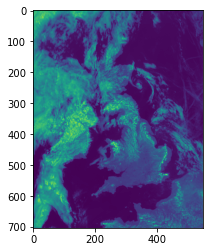

In [314]:
plt.imshow(predictions[0])

In [316]:
predictions.nbytes / 1E6

425.914368

In [317]:
predictions.dtype

dtype('float32')